# 1. Importing the Libraries and Dataset



In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import time
%matplotlib inline



train = pd.read_csv("mnist_train.csv")
test = pd.read_csv("mnist_test.csv")


# 2. Visualizing the dataset

[[5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 ...
 [5 0 0 ... 0 0 0]
 [6 0 0 ... 0 0 0]
 [8 0 0 ... 0 0 0]]
(60000, 785)


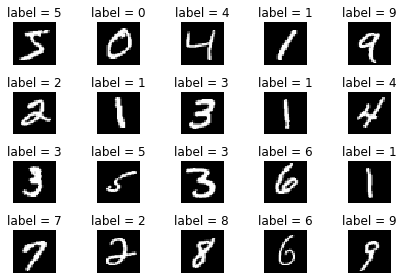

In [2]:
train_arr = np.array(train.values)
test_arr = np.array(test.values)
print(train_arr)
print(train_arr.shape)
for i in range(20):
    image = train_arr[i][1:].reshape(28, 28)
    plt.subplot(4, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title('label = {}'.format(train_arr[i][0]))
    plt.axis('off')
plt.tight_layout()
plt.show()

# 3. Model Architecture

* This is going to be a 3 layer nn model with 2 hidden layers
* The diementions of each of the hidden layer is [150,75]
* The input is a 28x28 image file which we are going to feed as a list of 784 (28x28) pixels
* The ouput will be checked with the label and the loss function would be standard lr loss function

# 4. Reshaping the datasets

In [3]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

X_train = train_arr[:,1:]
Y_train = train_arr[:,0].reshape(-1,1)
Y_train = enc.fit_transform(Y_train)
Y_train = Y_train.toarray()
X_train = X_train.T
X_train = np.array(X_train)
Y_train = Y_train.T
print(X_train.shape,Y_train.shape)
X_test = test_arr[:,1:]
Y_test = test_arr[:,0].reshape(-1,1)
X_test = X_test.T
Y_test = Y_test.T
X_test = np.array(X_test)
print(X_test.shape,Y_test.shape)

(784, 60000) (10, 60000)
(784, 10000) (1, 10000)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


# 5. Model Class

In [32]:
class gnn:
    def __init__(self, dims, activations, epochs, lr, b_size):
        self.dims = dims
        self.activations = activations
        self.epochs = epochs
        self.lr = lr
        self.b_size = b_size
        self.params={}
        self.grads={}
        self.initialize_parameters()
        
    def sigmoid(self,Z):
        A = 1/(1+np.exp(-Z))
        return A

    def relu(self,Z):
        A = np.maximum(0,Z)
        return A

    def relu_backward(self,dA, cache):
        Z = cache
        dZ = np.array(dA)
        dZ[Z <= 0] = 0
        return dZ

    def sigmoid_backward(self,dA, cache):
        Z = cache 
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)
        return dZ
    
    def initialize_parameters(self):
        dims = self.dims
        params = self.params
        L = len(dims)
        for l in range(1,L):
            params["W"+str(l)] = np.random.randn(dims[l],dims[l-1]) * np.sqrt(1. /dims[l])
            params["b"+str(l)] = np.zeros((dims[l],1))
        self.params = params
    
    def forward_prop(self,X):
        L = len(self.dims)
        params = self.params
        activations = self.activations
        params['A0'] = X
        
        for l in range(1,L):
            params["Z"+str(l)] = np.dot(params["W"+str(l)], params["A"+str(l-1)]) + params["b"+str(l)]
            if activations[l-1] == "relu":    
                params["A"+str(l)] = self.relu(params["Z"+str(l)])
            elif activations[l-1] == "sigmoid":    
                params["A"+str(l)] = self.sigmoid(params["Z"+str(l)])
        self.params = params
    
    def compute_cost(self,Y):
        L = len(self.dims)
        params = self.params
        AL = params["A" + str(L-1)]
        m = Y.shape[1]
        mse = np.sum((np.power(AL-Y,2)),axis=0,keepdims=True)
        cost = (1/10) * np.sum((1./m) * (np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T)))
        return cost
    
    def back_prop(self,Y):
        L = len(self.dims)
        m = Y.shape[1]
        params = self.params
        grads = self.grads
        activations = self.activations
        AL = params["A" + str(L-1)] 
        dA = np.divide(AL-Y, (1 - AL) *  AL)
        
        for l in reversed(range(1,L)):
            if(activations[l-1] == "relu"):
                dZ = self.relu_backward(dA, params["Z"+str(l)])
            elif(activations[l-1] == "sigmoid"):
                dZ = self.sigmoid_backward(dA, params["Z"+str(l)])
            grads["dW"+str(l)] = (1/m) * np.dot(dZ, params["A"+str(l-1)].T)
            grads["db"+str(l)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
            dA = np.dot(params["W"+str(l)].T, dZ)
        self.params = params
        self.grads = grads
    
    def update_params(self):
        L = len(self.dims)
        lr = self.lr
        grads = self.grads
        params = self.params
        for l in range(1,L):
            params["W"+str(l)] -= grads["dW"+str(l)]*lr
            params["b"+str(l)] -= grads["db"+str(l)]*lr
        params = self.params
    
    def accuracy(self, X_val, Y_val):
        self.forward_prop(X_val)
        L = len(self.dims)
        Y_predict = self.params["A"+str(L-1)]
        Y_pred = np.argmax(Y_predict, axis = 0).reshape(1,-1)
        m = Y_val.shape[1]
        preds = ((Y_val) == (Y_pred))
        unique, counts = np.unique(preds, return_counts=True)
        preds = dict(zip(unique, counts))
        print(preds)
        accu = ((preds[True])/m)*100
        return accu
    
    def train(self, X, Y, X_val, Y_val):
        costs = []
        accus = []
        b_size = self.b_size
        m = Y.shape[1]
        n_batches = m//b_size
        start_time = time.time()
        for i in range(self.epochs):
            ll = 0
            for j in range(n_batches):
                ul = ll + b_size-1
                XT = X[:,ll:ul]
                YT = Y[:,ll:ul]
                self.forward_prop(XT)

                cost = self.compute_cost(YT)
                self.back_prop(YT)

                self.update_params()

                
                ll += b_size
                
            costs.append(cost)
            accu = self.accuracy(X_val, Y_val)
            accus.append(accu)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2}, Cost: {3}'.format(
                    i+1, time.time() - start_time, accu, cost))
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('epochs')
        plt.title("Learning rate =" + str(self.lr))
        plt.show()
        
        plt.plot(np.squeeze(accus))
        plt.ylabel('accuracy')
        plt.xlabel('epochs')
        plt.title("Learning rate =" + str(self.lr))
        plt.show()
            

# 7. Training the model

{False: 1245, True: 8755}
Epoch: 1, Time Spent: 0.64s, Accuracy: 87.55, Cost: -2.3081448548599304
{False: 1049, True: 8951}
Epoch: 2, Time Spent: 1.31s, Accuracy: 89.51, Cost: -2.3749475161205873
{False: 905, True: 9095}
Epoch: 3, Time Spent: 1.98s, Accuracy: 90.95, Cost: -2.434638136052556
{False: 835, True: 9165}
Epoch: 4, Time Spent: 2.68s, Accuracy: 91.64999999999999, Cost: -2.5062717622473376
{False: 755, True: 9245}
Epoch: 5, Time Spent: 3.38s, Accuracy: 92.45, Cost: -2.4928517585083703
{False: 746, True: 9254}
Epoch: 6, Time Spent: 4.08s, Accuracy: 92.54, Cost: -2.4534479570827696
{False: 705, True: 9295}
Epoch: 7, Time Spent: 4.83s, Accuracy: 92.95, Cost: -2.418241027494461
{False: 641, True: 9359}
Epoch: 8, Time Spent: 5.58s, Accuracy: 93.58999999999999, Cost: -2.515750494389363
{False: 684, True: 9316}
Epoch: 9, Time Spent: 6.34s, Accuracy: 93.16, Cost: -2.5762123964281467
{False: 629, True: 9371}
Epoch: 10, Time Spent: 7.11s, Accuracy: 93.71000000000001, Cost: -2.68478958546

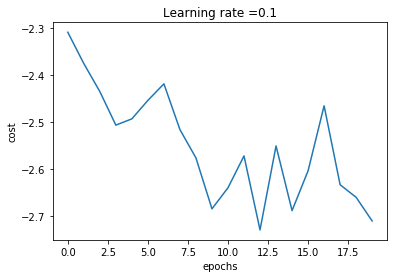

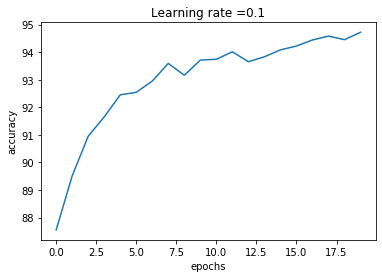

In [47]:
mnist = gnn(dims = [784,150,10], activations = ["sigmoid","sigmoid"], epochs = 20, lr = 0.1)
mnist.train(X_train, Y_train, X_test, Y_test)

# 6. Model performance

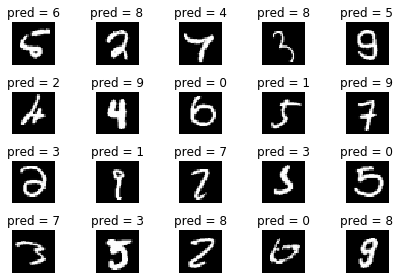

In [51]:
mnist.forward_prop(X_test)
Y_predict = mnist.params["A"+str(len(mnist.dims)-1)]
Y_pred = np.argmax(Y_predict, axis = 0).flatten()
i=0
p=0
for p in range(60000):
    if(test_arr[p][0] != Y_pred[p]):
        image = test_arr[p][1:].reshape(28, 28)
        plt.subplot(4, 5, i+1)
        plt.imshow(image, cmap='gray')
        plt.title('pred = {0}'.format(Y_pred[p]))
        plt.axis('off')
        i+=1
    if(i == 20):
        break
plt.tight_layout()
plt.show()

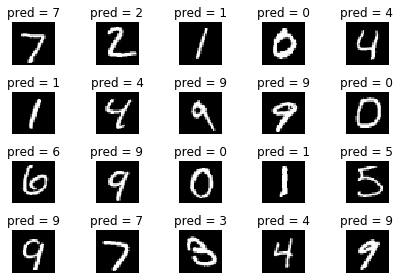

In [52]:
mnist.forward_prop(X_test)
Y_predict = mnist.params["A"+str(len(mnist.dims)-1)]
Y_pred = np.argmax(Y_predict, axis = 0).flatten()
i=0
p=0
for p in range(60000):
    if(test_arr[p][0] == Y_pred[p]):
        image = test_arr[p][1:].reshape(28, 28)
        plt.subplot(4, 5, i+1)
        plt.imshow(image, cmap='gray')
        plt.title('pred = {0}'.format(Y_pred[p]))
        plt.axis('off')
        i+=1
    if(i == 20):
        break
plt.tight_layout()
plt.show()

(-0.5, 27.5, 27.5, -0.5)

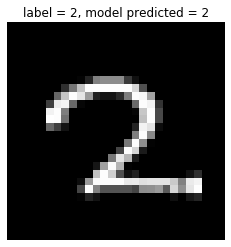

In [53]:
i=77
image = test_arr[i][1:].reshape(28, 28)
plt.imshow(image, cmap='gray')
plt.title('label = {0}, model predicted = {1}'.format(test_arr[i][0],Y_pred[i]))
plt.axis('off')

# 7.Input your own image (.png file with white background and black number)

[9]


(-0.5, 27.5, 27.5, -0.5)

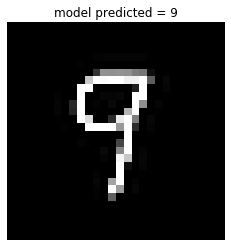

In [54]:
from PIL import Image, ImageFilter
def imageprepare(argv):
    im = Image.open(argv).convert('L')
    width = float(im.size[0])
    height = float(im.size[1])
    newImage = Image.new('L', (28, 28), (255))

    if width > height:
        nheight = int(round((20.0 / width * height), 0))
        if (nheight == 0):
            nheight = 1
        img = im.resize((20, nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight) / 2), 0))
        newImage.paste(img, (4, wtop))
    else:
        nwidth = int(round((20.0 / height * width), 0))
        if (nwidth == 0):
            nwidth = 1
        img = im.resize((nwidth, 20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth) / 2), 0))
        newImage.paste(img, (wleft, 4))

    tv = list(newImage.getdata())

    tva = [(255 - x) * 1.0 / 255.0 for x in tv]
    return tva

x=imageprepare('img9.png') #file path here (png)
x = np.array(x).reshape(-1,1)
mnist.forward_prop(x)
Y_predict = mnist.params["A"+str(len(mnist.dims)-1)]
Y_pred = np.argmax(Y_predict, axis = 0).flatten()
image = x.reshape(28, 28)
plt.imshow(image, cmap='gray')
print(Y_pred)
plt.title('model predicted = {0}'.format(Y_pred[0]))
plt.axis('off')